# PI-INN: Physics-Informed Invertible Neural Network
This notebook replicates the methodology and experiments from the paper:
**'Efficient Bayesian inference using physics-informed invertible neural networks for inverse problems'**
arXiv:2304.12541v3

*Unfortunately, the authors have not yet uploaded their code to GitHub. We used ChatGPT o4-mini-high to help replicate the author's code based on the paper by uploading the document. We prompting it to replicate the code as a Jupyter Notebook as described in the paper. From there, we made our own changes to the code with __ADD HERE__, and then devloped the code for the visuals and performance reports.*


## 1. Setup and Dependencies
Import necessary libraries and define helper functions.

In [3]:
import torch, time
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import multivariate_normal

## 2. Define Invertible Neural Network (INN) Modules
This section defines the affine coupling layers and full INN model.

In [4]:
# Affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.mask = mask
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, dim * 2)
        )
    def forward(self, x, reverse=False):
        x1 = x * self.mask
        x2 = x * (1 - self.mask)
        s_t = self.net(x1)
        s, t = s_t.chunk(2, dim=1)
        s = torch.tanh(s)
        if not reverse:
            y2 = x2 * torch.exp(s) + t
        else:
            y2 = (x2 - t) * torch.exp(-s)
        y = x1 + y2 * (1 - self.mask)
        logdet = ((1 - self.mask) * s).sum(dim=1)
        return y, logdet

# INN model
class INN(nn.Module):
    def __init__(self, dim, hidden_dim, n_layers):
        super().__init__()
        masks = [self._create_mask(dim, even=(i % 2 == 0)) for i in range(n_layers)]
        self.layers = nn.ModuleList([AffineCoupling(dim, hidden_dim, m) for m in masks])
    def _create_mask(self, dim, even=True):
        mask = torch.arange(dim) % 2
        if not even: mask = 1 - mask
        return mask.float()
    def forward(self, x):
        logdet_sum = 0
        for layer in self.layers:
            x, ld = layer(x, reverse=False)
            logdet_sum += ld
        return x, logdet_sum
    def inverse(self, z):
        logdet_sum = 0
        for layer in reversed(self.layers):
            z, ld = layer(z, reverse=True)
            logdet_sum += ld
        return z, logdet_sum

## 3. Define NB-Net and Physics-Informed Losses
This includes the spatial basis function network and PDE constraints.

In [5]:
# NB-Net: Basis network
class NBNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_basis):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden_dim] * 4 + [num_basis]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2: layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        # x: [batch, dim], returns [batch, num_basis]
        return self.net(x)

# PI-INN wrapper
class PI_INN(nn.Module):
    def __init__(self, lam_dim, z_dim, hidden_dim, n_coupling, nb_in_dim, nb_hidden, nb_basis):
        super().__init__()
        self.inn = INN(lam_dim, hidden_dim, n_coupling)
        self.nbnet = NBNet(nb_in_dim, nb_hidden, nb_basis)
        self.lam_dim, self.z_dim, self.nb_basis = lam_dim, z_dim, nb_basis
    def forward(self, lam):
        # lam -> [c,z]
        yz, logdet = self.inn(lam)
        c, z = yz[:, :self.nb_basis], yz[:, self.nb_basis:]
        return c, z, logdet
    def inverse(self, c, z):
        yz = torch.cat([c, z], dim=1)
        lam, logdet = self.inn.inverse(yz)
        return lam, logdet
    def decode(self, coords, c):
        # coords: [M, coord_dim], c: [batch, nb_basis]
        # produce u predictions at coords for each batch
        # NB-Net outputs Phi; then u = Phi @ c
        Phi = self.nbnet(coords)        # [M, P]
        u = Phi @ c.T                   # [M, batch]
        return u.T                      # [batch, M]

## 4. Dataset generation

In [6]:
def generate_ik_data(N):
    # x1 ~ N(0,0.25), x2,x3,x4 ~ N(0,0.5)
    sig = torch.tensor([0.25,0.5,0.5,0.5])
    lam = torch.randn(N,4) * sig
    l1,l2,l3 = 0.5,0.5,1.0
    x1,x2,x3,x4 = lam[:,0],lam[:,1],lam[:,2],lam[:,3]
    y1 = l1*torch.cos(x2) + l2*torch.cos(x3-x2) + l3*torch.cos(x4-x2-x3)
    y2 = x1 + l1*torch.sin(x2) + l2*torch.sin(x3-x2) + l3*torch.sin(x4-x2-x3)
    y = torch.stack([y1,y2], dim=1)
    return lam, y

## 5. Training PI-INN on inverse kinematics with different loss functions

In [7]:
# Define device first
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `device` is already defined as 'cuda' or 'cpu'
lam_dim, z_dim, hidden_dim, n_coupling = 4, 2, 48, 8
nb_dim, nb_hidden, nb_basis = None, None, None  # not used here

# Instantiate models
inn_ind = INN(lam_dim, hidden_dim, n_coupling)
inn_mmd = INN(lam_dim, hidden_dim, n_coupling)

optimizer_ind = optim.Adam(inn_ind.parameters(), lr=5e-4)
optimizer_mmd = optim.Adam(inn_mmd.parameters(), lr=5e-4)

# prepare
lam_train, y_train = generate_ik_data(4000)
dataset = TensorDataset(lam_train, y_train)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
start = time.time()
epochs = 1200
alpha, beta, gamma = 1.0, 0.1, 10.0

In [8]:
def independence_loss(logq_joint, logq_cz, logp_z, logq_cz2, logp_z2):
    # Eq (10) from the paper
    return torch.mean(((logq_joint - logq_cz2) - (logp_z - logp_z2))**2)

def inverse_multiquadratic_kernel(x, y, h=1.2):
    # x: [N, D], y: [M, D]
    diff = (x.unsqueeze(1) - y.unsqueeze(0)) / h  # [N, M, D]
    dist_sq = (diff ** 2).sum(dim=2)             # [N, M]
    return 1.0 / (1.0 + dist_sq)

def mmd_loss(p_samples, q_samples, h=1.2):
    K_pp = inverse_multiquadratic_kernel(p_samples, p_samples, h)
    K_qq = inverse_multiquadratic_kernel(q_samples, q_samples, h)
    K_pq = inverse_multiquadratic_kernel(p_samples, q_samples, h)

    mmd = K_pp.mean() + K_qq.mean() - 2 * K_pq.mean()
    return mmd

In [9]:
loss_history_indep = []
for epoch in range(epochs):
    epoch_loss = 0
    for lam_batch, y_batch in loader:
        yz, logdet = inn_ind(lam_batch)
        y_hat = yz[:, :2]
        z_hat = yz[:, 2:]
        z = torch.randn_like(z_hat)

        yz_swapped = torch.cat([y_batch, z], dim=1)
        lam_recon, logdet_inv = inn_ind.inverse(yz_swapped)
        yz_recon, _ = inn_ind(lam_recon)
        z_recon = yz_recon[:, 2:]

        # 1. Fit loss
        loss_fit = torch.mean((y_hat - y_batch) ** 2)

        logq_joint = -0.5 * torch.sum(lam_batch ** 2, dim=1) + logdet
        logq_cz2 = -0.5 * torch.sum(lam_recon ** 2, dim=1) + logdet_inv
        logp_z = -0.5 * torch.sum(z_hat ** 2, dim=1)
        logp_z2 = -0.5 * torch.sum(z ** 2, dim=1)

        loss_indep = independence_loss(logq_joint, logq_joint, logp_z, logq_cz2, logp_z2)

        total_loss = alpha * loss_fit + beta * loss_indep

        optimizer_ind.zero_grad()
        total_loss.backward()
        optimizer_ind.step()

        epoch_loss += total_loss.item()

    loss_history_indep.append(epoch_loss / len(loader))
    if epoch % 50 == 0:
        print(f"[Indep] Epoch {epoch} | Loss: {total_loss:.4f}")

[Indep] Epoch 0 | Loss: 0.6261
[Indep] Epoch 50 | Loss: 0.0023
[Indep] Epoch 100 | Loss: 0.0048
[Indep] Epoch 150 | Loss: 0.0011
[Indep] Epoch 200 | Loss: 0.0018
[Indep] Epoch 250 | Loss: 0.0007
[Indep] Epoch 300 | Loss: 0.0011
[Indep] Epoch 350 | Loss: 0.0006
[Indep] Epoch 400 | Loss: 0.0009
[Indep] Epoch 450 | Loss: 0.0007
[Indep] Epoch 500 | Loss: 0.0003
[Indep] Epoch 550 | Loss: 0.0006
[Indep] Epoch 600 | Loss: 0.0007
[Indep] Epoch 650 | Loss: 0.0003
[Indep] Epoch 700 | Loss: 0.0006
[Indep] Epoch 750 | Loss: 0.0003
[Indep] Epoch 800 | Loss: 0.0008
[Indep] Epoch 850 | Loss: 0.0006
[Indep] Epoch 900 | Loss: 0.0005
[Indep] Epoch 950 | Loss: 0.0005
[Indep] Epoch 1000 | Loss: 0.0004
[Indep] Epoch 1050 | Loss: 0.0003
[Indep] Epoch 1100 | Loss: 0.0002
[Indep] Epoch 1150 | Loss: 0.0009


In [11]:
mmd_loss_history = []

for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0

    for lam_batch, y_batch in loader:
      lam_batch = lam_batch
      y_batch = y_batch
      # Forward: lam → [y_hat | z_hat]
      yz, logdet = inn_mmd(lam_batch)
      y_hat = yz[:, :2]
      z_hat = yz[:, 2:]

      # Sample prior z
      z = torch.randn_like(z_hat)

      # Inverse: (y_batch, z) → lam_recon
      yz_swapped = torch.cat([y_batch, z], dim=1)
      lam_recon, _ = inn_mmd.inverse(yz_swapped)

      # Forward again: lam_recon → [y_recon | z_recon]
      yz_recon, _ = inn_mmd(lam_recon)
      y_recon = yz_recon[:, :2]
      z_recon = yz_recon[:, 2:]

      # 1. Fit loss
      loss_fit = torch.mean((y_hat - y_batch) ** 2)

      # 2. MMD between (y, z) joint samples from prior and q
      p_yz = torch.cat([y_batch, z], dim=1)        # [N, D_y + D_z]
      q_yz = torch.cat([y_recon, z_recon], dim=1)   # [N, D_y + D_z]
      loss_mmd_yz = mmd_loss(p_yz, q_yz)

      # 3. MMD between lam_batch (input prior) and lam_recon (reconstructed)
      loss_mmd_x = mmd_loss(lam_batch, lam_recon)

      # Combine total loss
      total_loss = alpha * loss_fit + beta * loss_mmd_yz + gamma * loss_mmd_x

      optimizer_mmd.zero_grad()
      total_loss.backward()
      optimizer_mmd.step()

      epoch_loss += total_loss.item()
      num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    mmd_loss_history.append(avg_epoch_loss)

    if epoch in [400, 600, 1000]:
        for g in optimizer_mmd.param_groups:
            g['lr'] *= 0.8

    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {avg_epoch_loss:.6f} | Fit: {loss_fit:.4f} | MMD_yz: {loss_mmd_yz:.4f} | MMD_x: {loss_mmd_x:.4f}")


Epoch    0 | Total Loss: 2.648632 | Fit: 0.6670 | MMD_yz: 0.0000 | MMD_x: 0.0494
Epoch   50 | Total Loss: 0.157207 | Fit: 0.0178 | MMD_yz: 0.0000 | MMD_x: 0.0156
Epoch  100 | Total Loss: 0.133790 | Fit: 0.0152 | MMD_yz: 0.0000 | MMD_x: 0.0169
Epoch  150 | Total Loss: 0.136863 | Fit: 0.0140 | MMD_yz: 0.0000 | MMD_x: 0.0175
Epoch  200 | Total Loss: 0.128914 | Fit: 0.0089 | MMD_yz: 0.0000 | MMD_x: 0.0176
Epoch  250 | Total Loss: 0.122473 | Fit: 0.0135 | MMD_yz: -0.0000 | MMD_x: 0.0163
Epoch  300 | Total Loss: 0.127228 | Fit: 0.0137 | MMD_yz: 0.0000 | MMD_x: 0.0310
Epoch  350 | Total Loss: 0.115518 | Fit: 0.0119 | MMD_yz: 0.0000 | MMD_x: 0.0302
Epoch  400 | Total Loss: 0.122891 | Fit: 0.0084 | MMD_yz: 0.0000 | MMD_x: 0.0317
Epoch  450 | Total Loss: 0.100884 | Fit: 0.0111 | MMD_yz: 0.0000 | MMD_x: 0.0185
Epoch  500 | Total Loss: 0.113502 | Fit: 0.0036 | MMD_yz: 0.0000 | MMD_x: 0.0119
Epoch  550 | Total Loss: 0.116359 | Fit: 0.0062 | MMD_yz: -0.0000 | MMD_x: 0.0212
Epoch  600 | Total Loss: 0

In [12]:
# === Setup ===
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move models to the correct device after instantiation (This fix was applied in a previous cell)
# inn_ind.to(device)
# inn_mmd.to(device)

# === Utility Functions ===
def relative_l2_error(lam_true, lam_pred):
    numerator = torch.norm(lam_true - lam_pred, dim=1)
    denominator = torch.norm(lam_true, dim=1)
    return (numerator / denominator).mean().item()

def plot_corner(samples, method_name="INN", case_id=1):
    if isinstance(samples, torch.Tensor):
        samples = samples.detach().cpu().numpy()
    df = pd.DataFrame(samples, columns=[f"x{i+1}" for i in range(samples.shape[1])])
    g = sns.PairGrid(df, diag_sharey=False)
    g.map_lower(sns.scatterplot, s=10, alpha=0.4)
    g.map_diag(sns.histplot, kde=True, bins=30, color="skyblue")
    g.map_upper(sns.kdeplot, fill=True, cmap="Reds", thresh=0.05)
    plt.suptitle(f"Posterior Samples (Case {case_id}) - {method_name}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# === Posterior Sampling Functions ===
def sample_inn_posterior(inn_model, y_target, n_samples=1000):
    # Ensure y_target is on the correct device
    y_target = y_target.to(device)
    y_repeat = y_target.repeat(n_samples, 1)
    z = torch.randn(n_samples, z_dim).to(y_target.device) # z must be on the same device as y_repeat
    yz = torch.cat([y_repeat, z], dim=1)
    # Ensure inn_model is already on the correct device
    lam_samples, _ = inn_model.inverse(yz)
    return lam_samples

def sample_abc_posterior(y_target, N=10000, eps=0.035):
    lam_pool, y_pool = generate_ik_data(N)
    dist = torch.norm(y_pool - y_target.cpu(), dim=1) # Move y_target to CPU for comparison with y_pool
    accepted = lam_pool[dist < eps]
    return accepted

# === Evaluate Models on Multiple Test Cases ===
def evaluate_posteriors(case_ids, y_test, inn_ind, inn_mmd):
    # Ensure models are on the correct device before evaluation
    inn_ind.to(device)
    inn_mmd.to(device)
    for case_id in case_ids:
        y_obs = y_test[case_id:case_id+1]  # [1, 2]
        # Ensure y_obs is on the correct device
        y_obs = y_obs.to(device)
        print(f"\n--- Case {case_id+1} ---")

        # ABC
        samples_abc = sample_abc_posterior(y_obs.cpu()) # Pass y_obs on CPU to ABC function
        print(f"ABC accepted {len(samples_abc)} samples")

        # INN1 (independence)
        samples_inn1 = sample_inn_posterior(inn_ind, y_obs)

        # INN2 (MMD)
        samples_inn2 = sample_inn_posterior(inn_mmd, y_obs)

        # Plot (plotting functions handle moving back to CPU)
        plot_corner(samples_abc, method_name="ABC", case_id=case_id+1)
        plot_corner(samples_inn1, method_name="INN1 (indep)", case_id=case_id+1)
        plot_corner(samples_inn2, method_name="INN2 (MMD)", case_id=case_id+1)


--- Case 1 ---
ABC accepted 61 samples


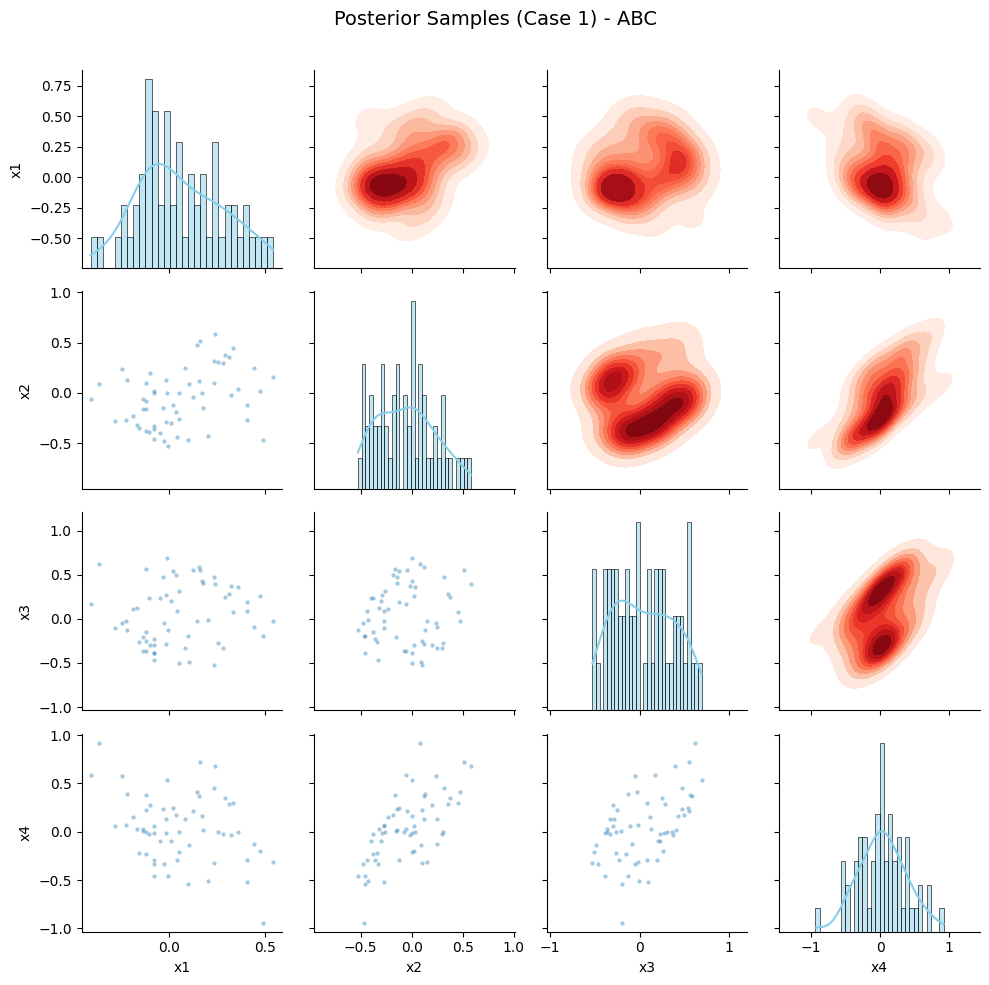

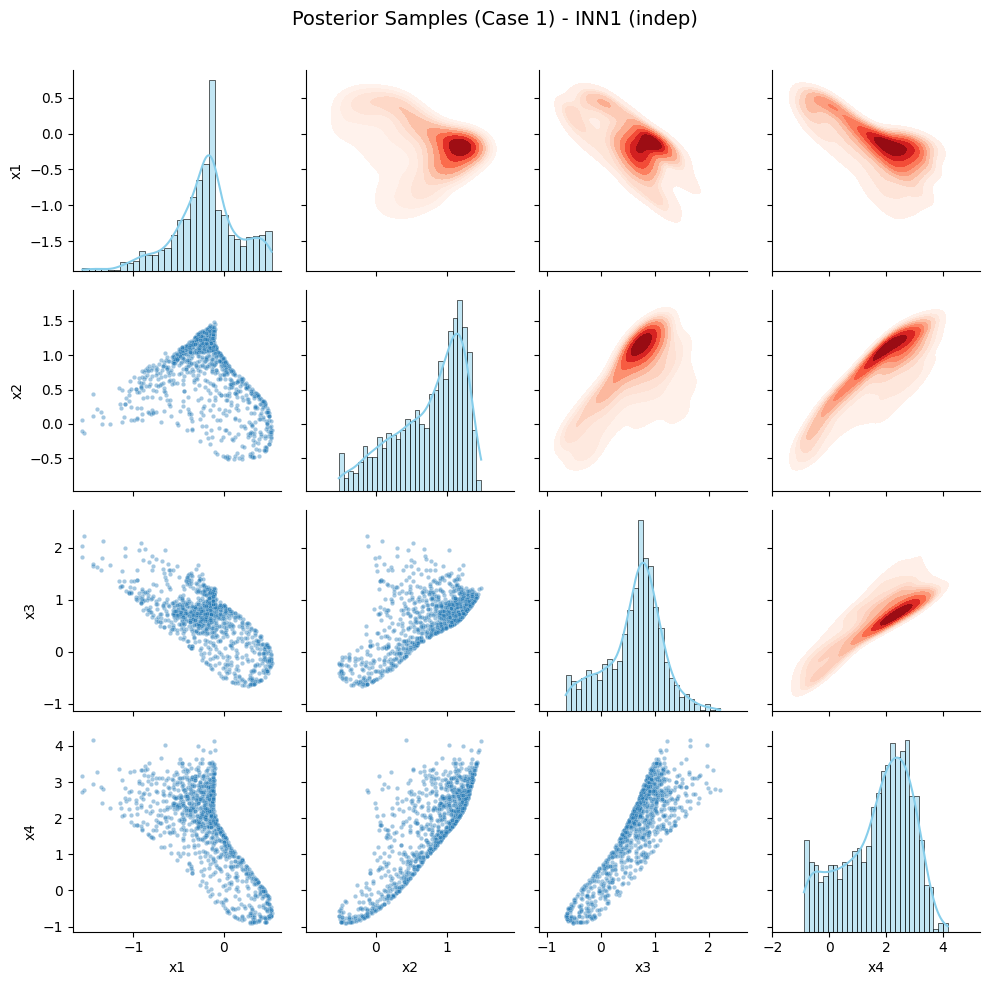

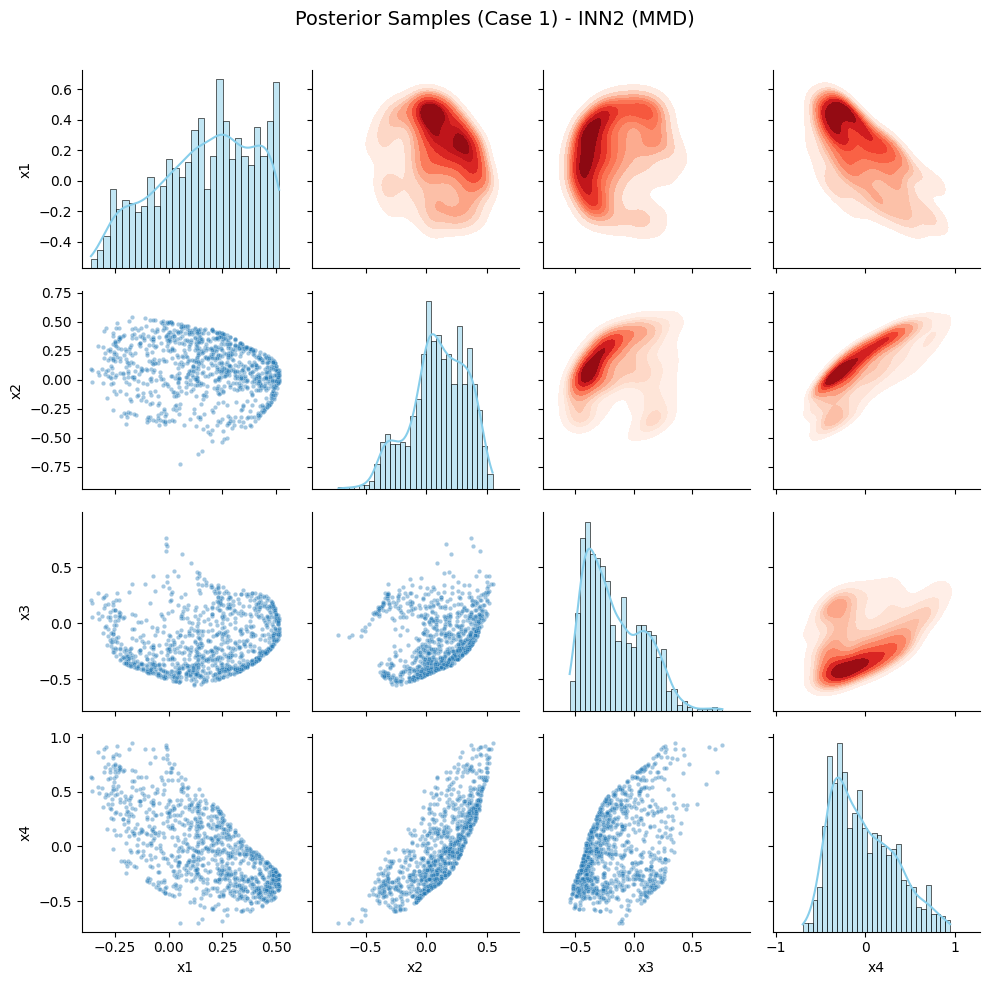


--- Case 2 ---
ABC accepted 33 samples


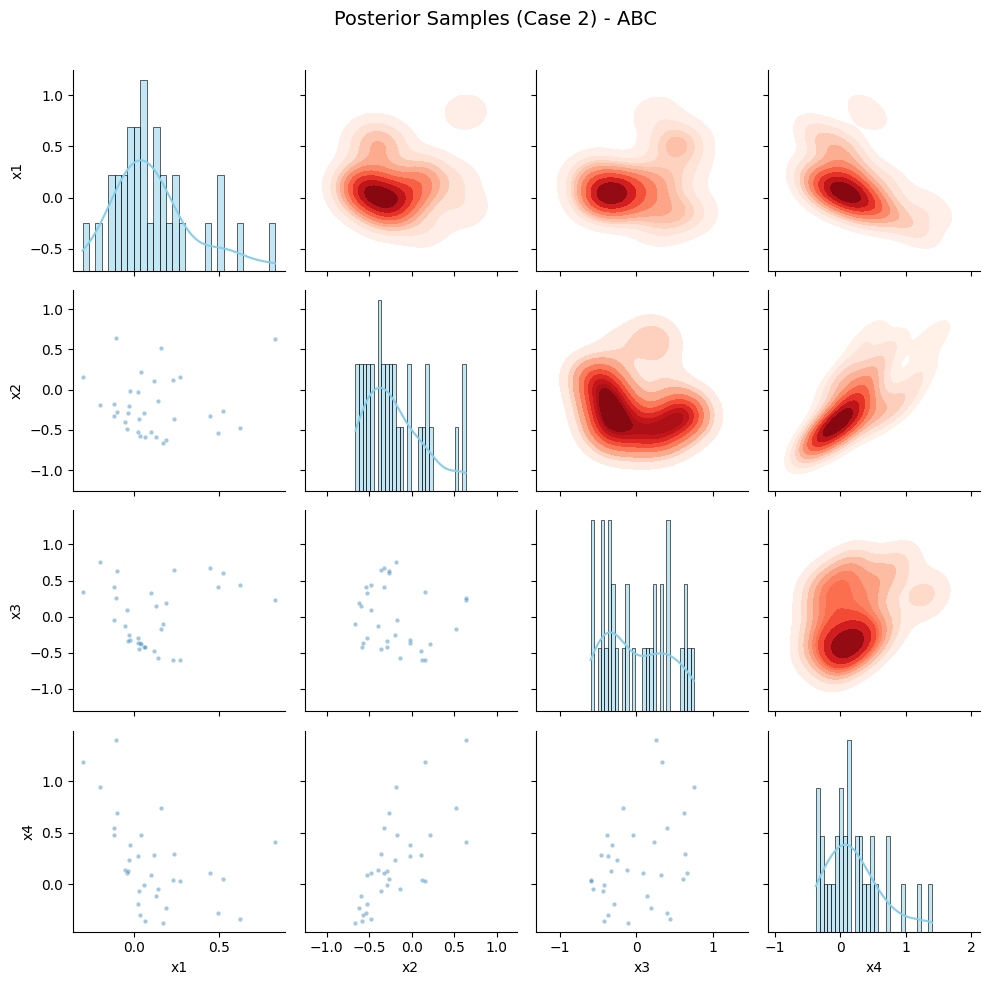

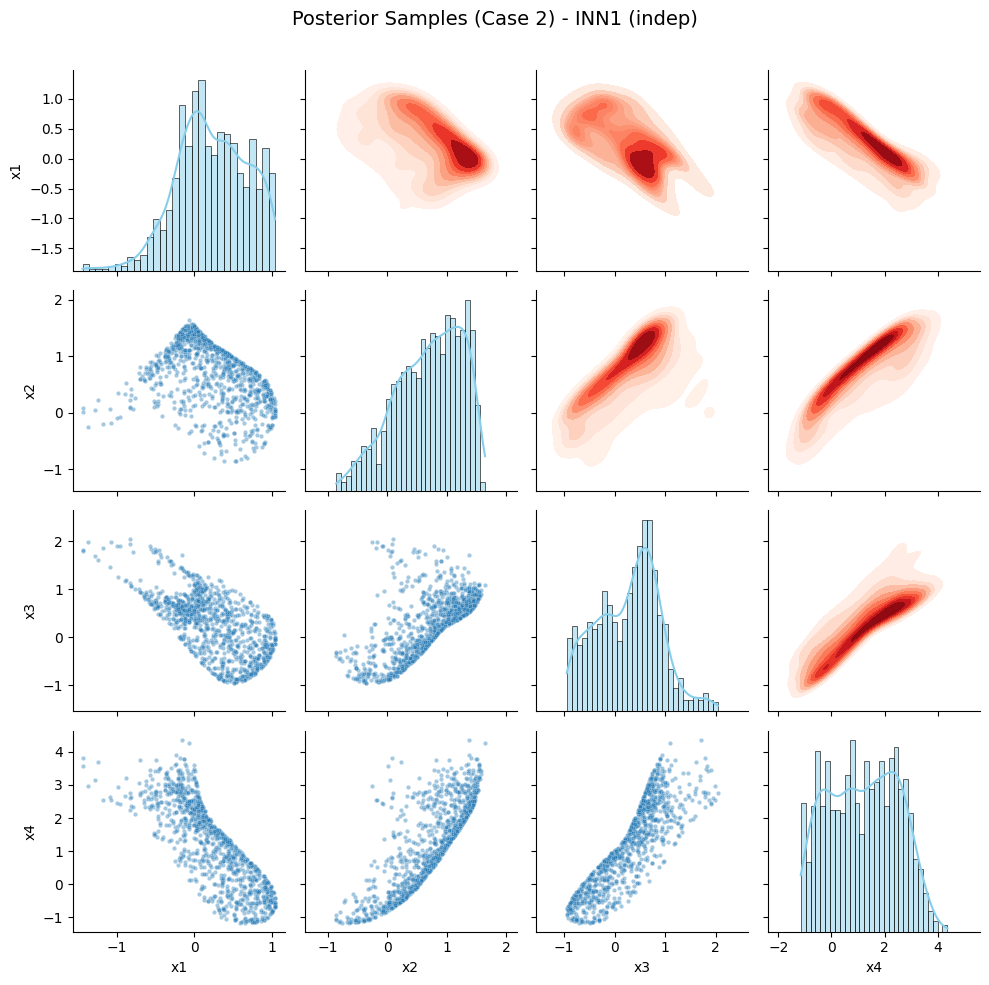

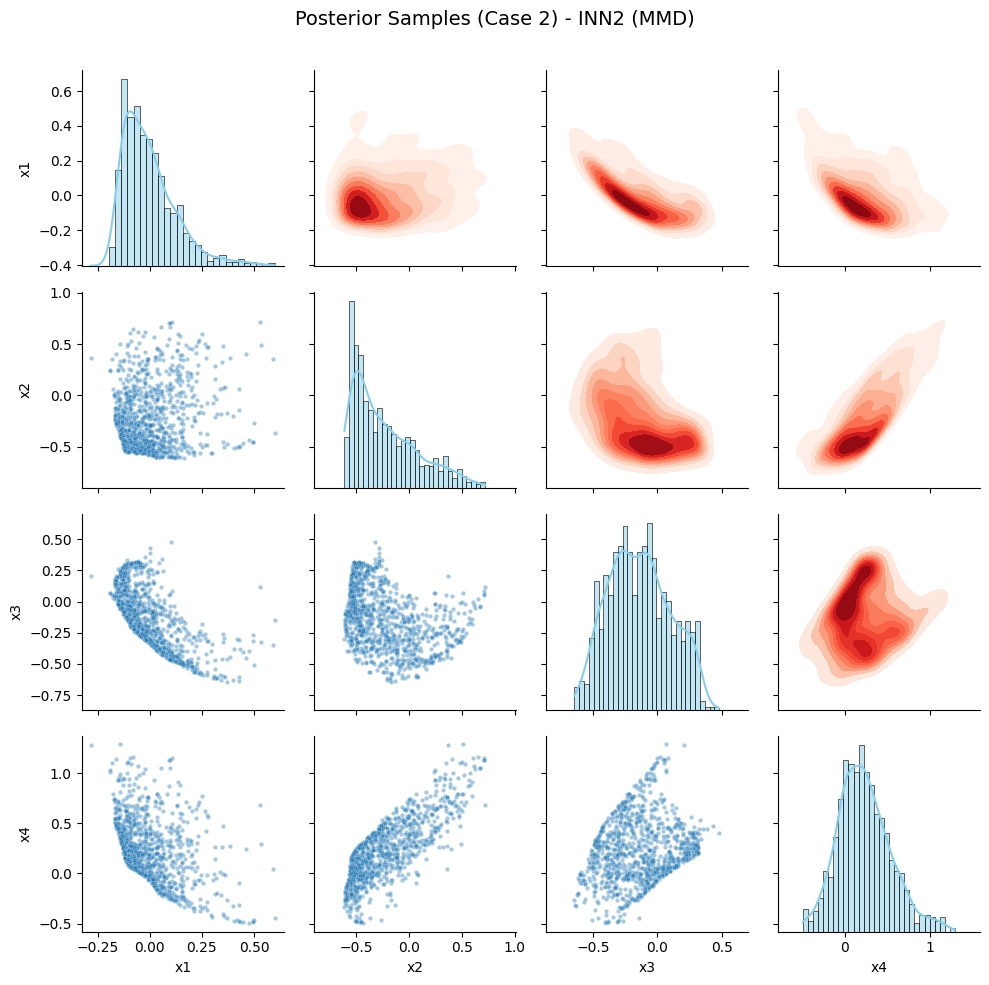

In [13]:
z_dim = 2
lam_test, y_test = generate_ik_data(1000)
y_test = y_test.to(device)

# Pick test cases to visualize
evaluate_posteriors(case_ids=[0, 1], y_test=y_test, inn_ind=inn_ind, inn_mmd=inn_mmd)

In [14]:
def compute_relative_l2_errors_best(y_test, lam_test, inn_ind, inn_mmd, n_samples=1000):
    errors_ind, errors_mmd, errors_abc = [], [], []
    for i in range(len(y_test)):
        y_obs = y_test[i:i+1]
        lam_true = lam_test[i:i+1].to(y_obs.device)

        # INN1
        lam_samples_ind = best_pred_from_samples(inn_ind, y_obs, n_samples)
        lam_pred_ind = find_best_lam(inn_ind, y_obs, lam_samples_ind)

        # INN2
        lam_samples_mmd = best_pred_from_samples(inn_mmd, y_obs, n_samples)
        lam_pred_mmd = find_best_lam(inn_mmd, y_obs, lam_samples_mmd)

        # ABC
        lam_abc = sample_abc_posterior(y_obs.cpu(), N=10000, eps=0.035)
        if len(lam_abc) == 0:
            # fallback if no samples accepted
            lam_pred_abc = torch.zeros_like(lam_true)
        else:
            # Find best ABC lam by forward error
            y_abc_pred = inn_ind(lam_abc.to(y_obs.device))[0][:, :y_obs.shape[1]]
            errors_abc_all = torch.norm(y_abc_pred - y_obs, dim=1)
            best_abc_idx = torch.argmin(errors_abc_all)
            lam_pred_abc = lam_abc[best_abc_idx:best_abc_idx+1].to(y_obs.device)

        # Compute errors
        errors_ind.append(relative_l2_error(lam_true, lam_pred_ind))
        errors_mmd.append(relative_l2_error(lam_true, lam_pred_mmd))
        errors_abc.append(relative_l2_error(lam_true, lam_pred_abc))

    print(f"Mean Relative L2 Error INN1: {torch.tensor(errors_ind).mean():.4f}")
    print(f"Mean Relative L2 Error INN2: {torch.tensor(errors_mmd).mean():.4f}")
    print(f"Mean Relative L2 Error ABC:  {torch.tensor(errors_abc).mean():.4f}")

    return errors_ind, errors_mmd, errors_abc

def best_pred_from_samples(inn_model, y_obs, n_samples=1000):
    y_repeat = y_obs.repeat(n_samples, 1)
    z = torch.randn(n_samples, z_dim).to(y_obs.device)
    yz = torch.cat([y_repeat, z], dim=1)
    lam_samples, _ = inn_model.inverse(yz)
    return lam_samples

def find_best_lam(inn_model, y_obs, lam_samples):
    y_pred, _ = inn_model(lam_samples)
    y_pred = y_pred[:, :y_obs.shape[1]]
    errors = torch.norm(y_pred - y_obs, dim=1)
    best_idx = torch.argmin(errors)
    return lam_samples[best_idx:best_idx+1]

Mean Relative L2 Error INN1: 2.5190
Mean Relative L2 Error INN2: 0.9963
Mean Relative L2 Error ABC:  1.1836


<ipython-input-15-9c76abcfd761>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Method", y="Relative L2 Error", palette="Set2")


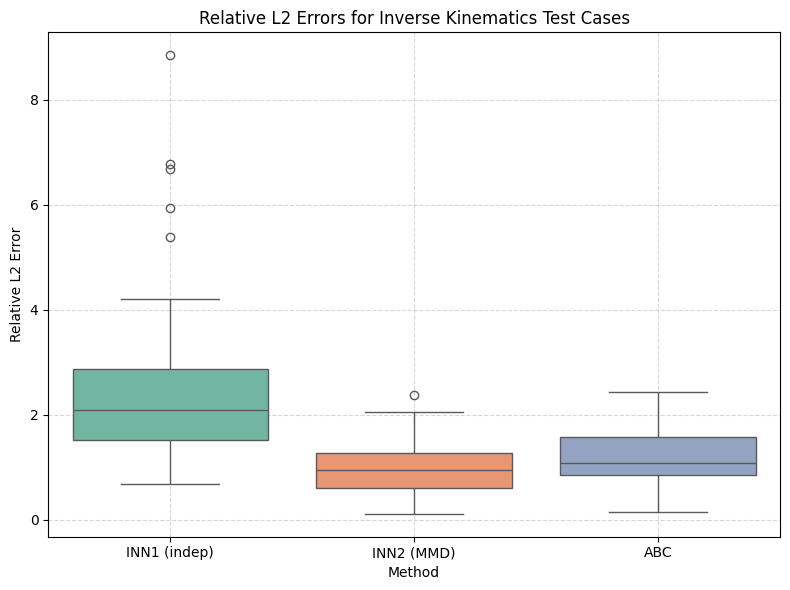

In [15]:
errors_ind, errors_mmd, errors_abc = compute_relative_l2_errors_best(y_test[:50], lam_test[:50], inn_ind, inn_mmd)
df = pd.DataFrame({
    "INN1 (indep)": errors_ind,
    "INN2 (MMD)": errors_mmd,
    "ABC": errors_abc
})
df_melted = df.melt(var_name="Method", value_name="Relative L2 Error")

# Plot boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melted, x="Method", y="Relative L2 Error", palette="Set2")
plt.title("Relative L2 Errors for Inverse Kinematics Test Cases")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()